In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
import tensorflow 
from sklearn import decomposition
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

C:\Users\Abhishek Kumar\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\Users\Abhishek Kumar\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\Users\Abhishek Kumar\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:43: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
dataset = pd.read_csv('Covid dataset.csv')
X = dataset 

In [4]:
X.head()

,review
0,Basically what the title says. I only leave my...
1,I’m surprised I got approved for a Best Buy ca...
2,I’ve been in my house (with my wife and young ...
3,"Hello everyone. First of all, I'm sorry if the..."
4,My anxiety is in high gear right now. We are r...


In [19]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, len( dataset['review'])):
    review = dataset['review'][i]
    review = re.sub(r'#[a-zA-Z0-9]+'," ", review)
    review = re.sub(r'@[a-zA-Z0-9]+', ' ', review)
    review = re.sub(r'&[a-zA-Z0-9]+', ' ', review)
    review = re.sub(r'RT[\s]+', ' ', review)
    review = re.sub(r"https?:\/\/\S+|www\S+|", "", review)
    review = re.sub(r'\\[a-zA-Z0-9]+', ' ', review)
    review = re.sub(r'^[a-zA-Z0-9]+'," ", review)
    review = re.sub(r'[^a-zA-Z]+'," ", review)
    review = review.lower()
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [20]:
corpus[11]

'even pm est pm gmt u davpel answer question experi pfizer vaccin programm say hi tester pfizer program know certain placebo feel comfort vaccin everyth read safeti protocol look good realm possibl someth could show later pretti unlik given number test subject certainli know lot time vaccin wide avail side effect hour feel yucki inject well worth ask pleas come back pm est ama back gener sticki week coupl request academ studi look particip pleas help way dm academ make request question would like inform first one u marysmirnova look differ type journal impact pandem relat stress feel stress someon close may expos coronaviru conduct studi examin differ type journal impact pandem relat stress elig particip studi earn complet questionnair journal entri onlin adult older live u interest studi pleas email us unrjournalingstudi com mailto unrjournalingstudi com subject line interest studi send onlin survey determin whether might elig particip second u soarinstitutecwru look impact covid chil

In [21]:
corpus

['titl say leav hous walk dog go supermarket extrem caution besid peopl live physic contact anyon sinc march neighbour hand social distanc far see still friend constantli fuck around street properti mean time someon hous need leav walk right past seven year old son covid symptom past day still allow play outsid street day come back walk dog child came run driveway pet like often start told friendliest voic could pet dog right great boy understand child even seem bother judg parent reaction would sworn said someth complet unreason start condescendingli explain dog get viru worri calmli told elderli immunocompromis rel child sick realli want take chanc scof act like complet line everi time left hous sinc made kind snide comment somehow hypocrit walk dog want anyon pet know peopl ever dog dog owner typic take dog walk benefit stranger might want pet issu never even dog first place want germ infest child potenti pass viru onto non confront person planet prolong passiv aggress realli upset 

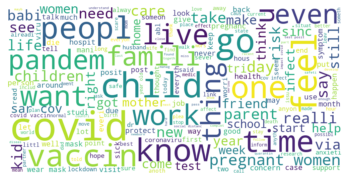

In [22]:
all = ' '.join([twts for twts in corpus] )
wordCloud= WordCloud(width = 1000,height = 500, random_state=0,background_color='White',max_font_size=119).generate(all)

plt.imshow(wordCloud,interpolation = "bilinear")
plt.axis('off')
plt.show()

In [23]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Abhishek
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
cader=[]
for i in range(0,len( X)):
    cader.append(vader.polarity_scores(corpus[i]))



X["Vader_Sentiment"] = cader
cader

[{'neg': 0.099, 'neu': 0.712, 'pos': 0.189, 'compound': 0.9393},
 {'neg': 0.083, 'neu': 0.539, 'pos': 0.378, 'compound': 0.9871},
 {'neg': 0.059, 'neu': 0.839, 'pos': 0.101, 'compound': 0.296},
 {'neg': 0.059, 'neu': 0.857, 'pos': 0.084, 'compound': 0.6124},
 {'neg': 0.163, 'neu': 0.714, 'pos': 0.123, 'compound': -0.296},
 {'neg': 0.177, 'neu': 0.657, 'pos': 0.166, 'compound': -0.5434},
 {'neg': 0.065, 'neu': 0.825, 'pos': 0.111, 'compound': 0.25},
 {'neg': 0.093, 'neu': 0.777, 'pos': 0.13, 'compound': 0.5423},
 {'neg': 0.141, 'neu': 0.587, 'pos': 0.271, 'compound': 0.9981},
 {'neg': 0.106, 'neu': 0.704, 'pos': 0.19, 'compound': 0.8885},
 {'neg': 0.126, 'neu': 0.722, 'pos': 0.152, 'compound': 0.743},
 {'neg': 0.035, 'neu': 0.799, 'pos': 0.166, 'compound': 0.9896},
 {'neg': 0.045, 'neu': 0.832, 'pos': 0.123, 'compound': 0.969},
 {'neg': 0.115, 'neu': 0.698, 'pos': 0.187, 'compound': 0.9568},
 {'neg': 0.19, 'neu': 0.625, 'pos': 0.184, 'compound': -0.2263},
 {'neg': 0.119, 'neu': 0.749, '

In [25]:
Vader_Senti = []

for i in range(0,len( X)):
    if cader[i]['compound']>= 0 :
        Vader_Senti.append('Positive')
    elif cader[i]['compound']<0 :
        Vader_Senti.append('Negative')
    
        
X["Vader Sentiment"] = Vader_Senti
X


,review,Vader_Sentiment,Vader Sentiment,Sentiments
0,Basically what the title says. I only leave my...,"{'neg': 0.099, 'neu': 0.712, 'pos': 0.189, 'co...",Positive,1
1,I’m surprised I got approved for a Best Buy ca...,"{'neg': 0.083, 'neu': 0.539, 'pos': 0.378, 'co...",Positive,1
2,I’ve been in my house (with my wife and young ...,"{'neg': 0.059, 'neu': 0.839, 'pos': 0.101, 'co...",Positive,1
3,"Hello everyone. First of all, I'm sorry if the...","{'neg': 0.059, 'neu': 0.857, 'pos': 0.084, 'co...",Positive,1
4,My anxiety is in high gear right now. We are r...,"{'neg': 0.163, 'neu': 0.714, 'pos': 0.123, 'co...",Negative,0
...,...,...,...,...
3122,Your obligations towards a pregnant worker hav...,"{'neg': 0.0, 'neu': 0.756, 'pos': 0.244, 'comp...",Positive,1
3123,.@CHSBuffalo is introducing a universal #COVID...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",Positive,1
3124,More than 47 million women could lose access t...,"{'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp...",Negative,0
3125,#Lockdown లాక్ డౌన్- 70 లక్షల మహిళలకు గర్భం.. ...,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",Positive,1


In [26]:
# def subjectivity(review):
#     return TextBlob(review).sentiment.subjectivity
# def polarity(review):
#     return TextBlob(review).sentiment.polarity
# Polarity=[]
# Subjectivity=[]
# for i in range(0,len( dataset['tweet_text'])):aa
#     Polarity.append(polarity(corpus[i]))
#     Subjectivity.append(subjectivity(corpus[i]))

# Polarity = np.array(Polarity)
# Subjectivity = np.array(Subjectivity)


In [27]:
# len(Polarity)


In [28]:
# Subjectivity

In [29]:
# plt.figure(figsize=(10,10))
# for i in range(0, len(dataset['review'])-1):
#     plt.scatter(Polarity[i],Subjectivity[i],color='Blue')

# plt.title("Setiment Analysis")
# plt.xlabel("Polarity")
# plt.ylabel("Subjectivity")
# plt.show()


In [30]:
Sentiment=[]
for i in range(0,len(dataset['review'])):
    if (X['Vader Sentiment'][i] == 'Positive'):
        Sentiment.append(1)
    
    else:
        Sentiment.append(0)
Sentiment = np.array(Sentiment)

In [31]:
print(Sentiment)

dataset['Sentiments']=Sentiment

dataset.head()

[1 1 1 ... 0 1 1]


,review,Vader_Sentiment,Vader Sentiment,Sentiments
0,Basically what the title says. I only leave my...,"{'neg': 0.099, 'neu': 0.712, 'pos': 0.189, 'co...",Positive,1
1,I’m surprised I got approved for a Best Buy ca...,"{'neg': 0.083, 'neu': 0.539, 'pos': 0.378, 'co...",Positive,1
2,I’ve been in my house (with my wife and young ...,"{'neg': 0.059, 'neu': 0.839, 'pos': 0.101, 'co...",Positive,1
3,"Hello everyone. First of all, I'm sorry if the...","{'neg': 0.059, 'neu': 0.857, 'pos': 0.084, 'co...",Positive,1
4,My anxiety is in high gear right now. We are r...,"{'neg': 0.163, 'neu': 0.714, 'pos': 0.123, 'co...",Negative,0


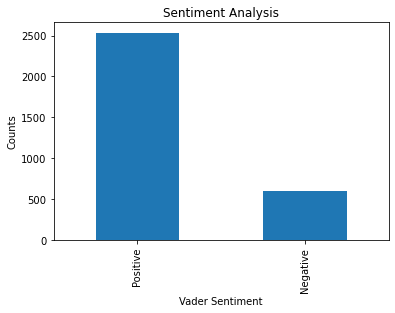

In [32]:


plt.title("Sentiment Analysis")
plt.xlabel("Vader Sentiment")
plt.ylabel("Counts")
dataset['Vader Sentiment'].value_counts().plot(kind="bar")
plt.show()

In [33]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [34]:
get_top_n_words(corpus, 10)

[('covid', 822),
 ('get', 510),
 ('pregnant', 428),
 ('child', 405),
 ('like', 395),
 ('go', 380),
 ('women', 380),
 ('vaccin', 377),
 ('time', 371),
 ('feel', 340)]

In [35]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return (final)

data_words = gen_words(corpus)

print (data_words[0][0:20])

['titl', 'say', 'leav', 'hous', 'walk', 'dog', 'go', 'supermarket', 'extrem', 'caution', 'besid', 'peopl', 'live', 'physic', 'contact', 'anyon', 'sinc', 'march', 'neighbour', 'hand']


In [36]:
id2word = corpora.Dictionary(data_words)

corpus_topic = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus_topic.append(new)

print (corpus_topic[0][0:20])

word = id2word[[0][:1][0]]
print (word)

[(0, 1), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 5), (16, 1), (17, 1), (18, 2), (19, 1)]
act


In [37]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_topic,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [38]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_topic, id2word, mds="mmds", R=10)
vis

C:\Users\Abhishek Kumar\anaconda3\envs\tensorflow_env\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.299026 -0.064641       1        1  42.734148
0      0.136939  0.326820       2        1  28.983539
4     -0.241178 -0.174231       3        1  15.709200
1     -0.214554  0.132212       4        1   7.601183
3      0.019767 -0.220160       5        1   4.971930, topic_info=            Term        Freq       Total Category  logprob  loglift
2140    pregnant  998.000000  998.000000  Default  10.0000  10.0000
24         covid  692.000000  692.000000  Default   9.0000   9.0000
2669       women  676.000000  676.000000  Default   8.0000   8.0000
761       worker  986.000000  986.000000  Default   7.0000   7.0000
1102  coronaviru  292.000000  292.000000  Default   6.0000   6.0000
...          ...         ...         ...      ...      ...      ...
5735     kbakanl   57.052204   59.034244   Topic5  -3.8936   2.9672
5736        nefe   57.052204   59.034244   Topic5  -3.8936   2.9672
511         fear   40.992359   42.549214   Topic5  -4.2242   2.9641
198        avail   38.449610   39.966543   Topic5  -4.2882   2.9627
1804         top   30.730844   32.232173   Topic5  -4.5123   2.9537

[65 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
379       1  0.014833  address
379       3  0.014833  address
379       5  0.964123  address
1306      1  0.006183  appoint
1306      3  0.989280  appoint
...     ...       ...      ...
124       1  0.996374     viru
186       1  0.995487     week
2669      1  0.001478    women
2669      2  0.997849    women
761       1  0.999231   worker

[99 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
vectorizer= TfidfVectorizer(stop_words={'english'})
X= vectorizer.fit_transform(corpus).toarray()

In [41]:
X[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [42]:
vectorizer.get_feature_names()

['ab',
 'abandon',
 'abbot',
 'abc',
 'abcnew',
 'abi',
 'abid',
 'abil',
 'abl',
 'abnorm',
 'abo',
 'abort',
 'abras',
 'abriu',
 'abroad',
 'abrupt',
 'abruptli',
 'absenc',
 'absent',
 'absolut',
 'absolv',
 'absorb',
 'absorpt',
 'abstract',
 'absurd',
 'abt',
 'abu',
 'abund',
 'abus',
 'ac',
 'academ',
 'academi',
 'acceler',
 'accept',
 'access',
 'accid',
 'accident',
 'accommod',
 'accomod',
 'accomodayion',
 'accompani',
 'accomplish',
 'accord',
 'accouch',
 'account',
 'accumul',
 'accur',
 'accuraci',
 'accus',
 'ace',
 'ach',
 'achi',
 'achiev',
 'acknowledg',
 'acn',
 'acog',
 'acquir',
 'acquitt',
 'across',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'acudan',
 'acut',
 'ad',
 'adam',
 'add',
 'addict',
 'addit',
 'address',
 'adequ',
 'adhd',
 'adher',
 'adjust',
 'administr',
 'admir',
 'admiss',
 'admit',
 'admittedli',
 'adn',
 'adolesc',
 'adopt',
 'ador',
 'adrift',
 'adult',
 'adulthood',
 'advanc',
 'advantag',
 'adventur',
 'advers',
 'advic',
 'advis'

In [43]:
clf = decomposition.NMF(n_components=5 , random_state=42)

W1 = clf.fit_transform(X)
H1 = clf.components_

C:\Users\Abhishek Kumar\anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [44]:
H1

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.66397496e-05, 0.00000000e+00, 1.64803835e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.51309012e-03, 1.37893365e-02, 2.10943384e-03, ...,
        1.12194424e-03, 7.18189678e-03, 8.23781902e-04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.57879162e-04, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 5.47295298e-04, 0.00000000e+00]])

In [45]:
W1

array([[0.        , 0.00703052, 0.14845299, 0.        , 0.        ],
       [0.        , 0.02873841, 0.15618119, 0.05514144, 0.        ],
       [0.00223763, 0.        , 0.08222947, 0.        , 0.01043898],
       ...,
       [0.02029165, 0.        , 0.01516962, 0.        , 0.05995382],
       [0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.06791844, 0.        , 0.01400517, 0.0086948 , 0.        ]])

In [46]:
num_words = 15
vocab = np.array(vectorizer.get_feature_names())
top_words = lambda t : [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]
topics

['women pregnant cov sar infect risk covid vaccin studi sever outcom among ill hospit increas',
 'learn news regain compound resili loss major impact student great lost kid help time like',
 'get child go know feel year one like mask time need vaccin work want peopl',
 'coronaviru tip pregnant pandem mom stress anytim healthi stay possibl help doctor share oximet puls',
 'pregnanc covid via vaccin nefe egzersizleri kbakanl exercis link birth latest risk babi sever affect']

In [47]:
col = ["Topic" + str(i) for i in range(clf.n_components)]
doc = ["Doc" + str(i) for i in range(len(corpus))]
df = pd.DataFrame(np.round(W1, 2),columns = col, index = doc)
significant_topic = np.argmax(df.values,axis =1)
df['Reliable_Topic'] = significant_topic
df


,Topic0,Topic1,Topic2,Topic3,Topic4,Reliable_Topic
Doc0,0.00,0.01,0.15,0.00,0.00,2
Doc1,0.00,0.03,0.16,0.06,0.00,2
Doc2,0.00,0.00,0.08,0.00,0.01,2
Doc3,0.00,0.00,0.16,0.01,0.01,2
Doc4,0.00,0.02,0.12,0.01,0.00,2
...,...,...,...,...,...,...
Doc3122,0.05,0.00,0.04,0.01,0.00,0
Doc3123,0.00,0.00,0.03,0.04,0.00,3
Doc3124,0.02,0.00,0.02,0.00,0.06,4
Doc3125,0.00,0.00,0.00,0.00,0.00,0


In [48]:
corpus[2]

'hous wife young child four week intent catch viru better catch viru would alreadi recov hear peopl recov covid feel weird feel mild jealousi anyon els'

In [49]:
Y = Sentiment
Y

array([1, 1, 1, ..., 0, 1, 1])

In [50]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [51]:
len(X_train)

2501

In [52]:
from sklearn.svm import SVC
classifierSVC = SVC(kernel = 'linear', random_state = 0)
classifierSVC.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [53]:
y_pred = classifierSVC.predict(X_test)

In [54]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 57,  59],
       [  5, 505]], dtype=int64)

In [56]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8977635782747604

In [57]:
from sklearn.naive_bayes import GaussianNB
classifiernb = GaussianNB()
classifiernb.fit(X_train, y_train)

GaussianNB()

In [58]:
y_nb = classifiernb.predict(X_test)

In [59]:
y_nb

array([1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0,

In [60]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_nb)

0.536741214057508

In [61]:
from sklearn.neighbors import KNeighborsClassifier
classifierknn = KNeighborsClassifier(n_neighbors=3 ,metric= 'minkowski' , p=2 )
classifierknn.fit(X_train , y_train)

KNeighborsClassifier(n_neighbors=3)

In [62]:
y_knn = classifierknn.predict(X_test)

In [63]:
y_knn

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [64]:
accuracy_score(y_test,y_knn)

0.8450479233226837

In [65]:
from sklearn.ensemble import RandomForestClassifier
classifierRF = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifierRF.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [66]:
y_RF=classifierRF.predict(X_test)
y_RF

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1,

In [67]:
accuracy_score(y_RF,y_test)

0.8801916932907349

In [68]:
from sklearn.tree import DecisionTreeClassifier
classifierDT = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifierDT.fit(X_train, y_train)
y_DT=classifierDT.predict(X_test)
y_DT


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,

In [69]:
accuracy_score(y_DT,y_test)

0.8738019169329073

In [70]:
y_test

array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,

In [71]:
from tensorflow.keras.preprocessing.text import one_hot

In [72]:
voc_size=10000
onehot_repr=[one_hot(words,voc_size)for words in corpus] 
print(onehot_repr)

[[4106, 6198, 1329, 2693, 6786, 8213, 464, 7354, 813, 6131, 8218, 2108, 1821, 3404, 9243, 1505, 1120, 7444, 9792, 2457, 6502, 7221, 3624, 6258, 2294, 8629, 7506, 4862, 5206, 8725, 2366, 4152, 31, 5227, 2693, 5929, 1329, 6786, 5480, 3276, 6759, 3893, 5529, 2267, 9111, 9163, 3276, 5978, 2294, 1164, 2522, 3819, 8725, 5978, 8355, 2018, 6786, 8213, 5935, 1731, 5560, 6854, 5059, 4447, 1517, 4967, 6260, 655, 8624, 5516, 5059, 8213, 5480, 5817, 4930, 7170, 5935, 9362, 7475, 6179, 8444, 5416, 5463, 6958, 2532, 7808, 3452, 7778, 5223, 4967, 1546, 1202, 8213, 6202, 3936, 9208, 1780, 6260, 1291, 4730, 4599, 5935, 7943, 6421, 2667, 9837, 5440, 6171, 3893, 4447, 7778, 1826, 9317, 31, 977, 2693, 1120, 9110, 5282, 8803, 7884, 3600, 4635, 6786, 8213, 2667, 1505, 5059, 2803, 2108, 9499, 8213, 8213, 7594, 6624, 9837, 8213, 6786, 4391, 3962, 8365, 2667, 5059, 9619, 5198, 9362, 8213, 161, 3134, 2667, 8471, 1710, 5935, 7753, 8400, 3936, 9812, 3910, 7763, 3723, 8984, 1560, 8132, 6550, 6421, 7462, 6198, 1429,

In [73]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential

In [98]:
sent_length=1900
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
embedded_docs

array([[   0,    0,    0, ..., 4447, 6543,  527],
       [   0,    0,    0, ..., 7125, 6258,  922],
       [   0,    0,    0, ..., 8895, 1505, 7043],
       ...,
       [   0,    0,    0, ..., 4282, 8355, 1373],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ..., 1329, 7135, 8313]])

In [99]:
model=Sequential()
model.add(Embedding(voc_size,10,input_length=sent_length))
model.compile('adam','mse')

In [100]:
X_WE = np.array(embedded_docs)


In [101]:
X_WE[0]

array([   0,    0,    0, ..., 4447, 6543,  527])

In [102]:
for i in range(0, len( dataset['review'])):
    corpus[i] = corpus[i].split()
    

In [103]:
corpus[1]

['surpris',
 'got',
 'approv',
 'best',
 'buy',
 'card',
 'know',
 'would',
 'done',
 'sure',
 'lot',
 'peopl',
 'go',
 'buy',
 'comput',
 'short',
 'notic',
 'sure',
 'lot',
 'peopl',
 'march',
 'figur',
 'school',
 'would',
 'back',
 'normal',
 'fall',
 'sinc',
 'comput',
 'anyth',
 'help',
 'peopl',
 'without',
 'would',
 'weird',
 'contact',
 'school',
 'see',
 'way',
 'could',
 'help',
 'kid',
 'know',
 'situat',
 'feel',
 'comfort',
 'go',
 'back',
 'school',
 'also',
 'comput',
 'home',
 'grew',
 'realli',
 'realli',
 'poor',
 'nobodi',
 'care',
 'idk',
 'help',
 'right',
 'want',
 'help',
 'least',
 'one',
 'person',
 'mom',
 'make',
 'decis',
 'possibl',
 'infect',
 'sick',
 'love',
 'one',
 'put',
 'child',
 'school',
 'stress',
 'love',
 'invit',
 'kid',
 'hous',
 'help',
 'anxieti',
 'know',
 'super',
 'weird',
 'reach',
 'school',
 'see',
 'help']

In [104]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Abhishek
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [105]:
from gensim.models import Word2Vec
model = Word2Vec(corpus, min_count = 2)


In [106]:
vector = model.wv['covid']
vector

array([ 7.9206067e-01, -8.5142654e-01,  1.0351107e+00, -1.6169143e-01,
       -1.7432088e-01,  5.9270048e-01, -5.6191422e-02,  3.7559468e-02,
        8.9182395e-01, -4.5352283e-01, -4.5169002e-01, -5.5512029e-01,
       -5.1684298e-02, -2.5030929e-01, -8.1445736e-01, -9.1680199e-01,
       -9.5535624e-01, -4.3833280e-01,  1.4186767e-01,  5.0676495e-01,
        3.4536412e-01, -3.0909276e-01,  7.2902441e-02, -3.4095865e-02,
       -4.7881067e-02, -3.4710842e-01,  6.7847259e-02,  2.6854813e-01,
        3.9140970e-02, -4.3509148e-02, -7.3542938e-02, -2.5009164e-01,
       -4.5422322e-01,  2.9911798e-01, -2.6792344e-01, -5.0999975e-01,
       -2.7916047e-01,  1.4994814e-01, -3.6414754e-01,  6.0052288e-01,
        7.6823032e-01,  6.1365473e-01,  1.7140146e-01, -1.9977525e-02,
        7.4964500e-04, -3.2736617e-01,  3.1350279e-01,  1.1105629e+00,
        1.5657648e-01, -1.0303686e+00,  4.5616798e-02,  6.2276280e-01,
       -1.1507784e+00, -7.1947473e-01,  1.2338116e-01,  3.1090611e-01,
      

In [107]:
class Sequencer():
    
    def __init__(self,
                 all_words,
                 max_words,
                 seq_len,
                 embedding_matrix
                ):
        
        self.seq_len = seq_len
        self.embed_matrix = embedding_matrix
        """
        temp_vocab = Vocab which has all the unique words
        self.vocab = Our last vocab which has only most used N words.
    
        """
        temp_vocab = list(set(all_words))
        self.vocab = []
        self.word_cnts = {}
        """
        Now we'll create a hash map (dict) which includes words and their occurencies
        """
        for word in temp_vocab:
            # 0 does not have a meaning, you can add the word to the list
            # or something different.
            count = len([0 for w in all_words if w == word])
            self.word_cnts[word] = count
            counts = list(self.word_cnts.values())
            indexes = list(range(len(counts)))
        
        # Now we'll sort counts and while sorting them also will sort indexes.
        # We'll use those indexes to find most used N word.
        cnt = 0
        while cnt + 1 != len(counts):
            cnt = 0
            for i in range(len(counts)-1):
                if counts[i] < counts[i+1]:
                    counts[i+1],counts[i] = counts[i],counts[i+1]
                    indexes[i],indexes[i+1] = indexes[i+1],indexes[i]
                else:
                    cnt += 1
        
        for ind in indexes[:max_words]:
            self.vocab.append(temp_vocab[ind])
                    
    def textToVector(self,text):
        # First we need to split the text into its tokens and learn the length
        # If length is shorter than the max len we'll add some spaces (100D vectors which has only zero values)
        # If it's longer than the max len we'll trim from the end.
        tokens = text.split()
        len_v = len(tokens)-1 if len(tokens) < self.seq_len else self.seq_len-1
        vec = []
        for tok in tokens[:len_v]:
            try:
                vec.append(self.embed_matrix[tok])
            except Exception as E:
                pass
        
        last_pieces = self.seq_len - len(vec)
        for i in range(last_pieces):
            vec.append(np.zeros(100,))
        
        return np.asarray(vec).flatten()

In [108]:
sequencer = Sequencer(all_words = [token for seq in corpus for token in seq],
              max_words = 1200,
              seq_len = 15,
              embedding_matrix = model.wv
             )

In [109]:
x_vecs = np.asarray([sequencer.textToVector(" ".join(seq)) for seq in corpus])
print(x_vecs.shape)

(3127, 1500)


In [110]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=90)
pca_model.fit(x_vecs)
print("Sum of variance ratios: ",sum(pca_model.explained_variance_ratio_))

Sum of variance ratios:  0.9998276571311074


In [111]:
x_comps = pca_model.transform(x_vecs)
x_comps.shape
x_comps[0]

array([ 4.14726036e+00,  8.20303587e-01, -7.23642161e-01, -3.35714567e+00,
        1.61577097e+00, -6.83664631e-01,  8.03094005e-01,  2.05248565e-01,
        4.30062958e+00, -1.34953468e+00, -2.78239654e+00,  3.97873465e-01,
       -2.15216170e+00,  1.65509486e+00, -5.04113427e-02,  1.39525301e-02,
       -4.78576383e-02, -1.18971278e-02, -3.63198338e-02, -4.33885832e-03,
       -3.31961281e-04, -1.06748543e-03, -1.73530732e-02, -3.83416161e-02,
       -2.03729453e-02, -2.90891999e-02,  1.12402038e-02,  2.01952240e-03,
        7.95859930e-03,  7.90317256e-03,  6.93552511e-03,  1.74828003e-03,
       -1.03130528e-02, -5.61572447e-03,  1.01073755e-02, -4.75763015e-03,
        1.36774904e-02,  6.12405154e-04,  5.59899378e-03, -3.71563213e-04,
        1.58850867e-02,  9.17320383e-03,  9.61347495e-04, -3.08046691e-03,
       -6.00207224e-03, -1.10123638e-02, -7.00125050e-03, -4.54605304e-03,
       -5.91661393e-04, -1.79245583e-03, -4.84457923e-03,  7.26702870e-03,
       -1.28419475e-03,  

In [116]:
x_train_w2v,x_test_w2v,y_train,y_test = train_test_split(x_comps,Y,test_size=0.2,random_state=42)
x_train_w2v

array([[ 5.55903827e+00,  2.03396148e-01,  1.18488005e+00, ...,
         1.45580802e-02,  1.17483454e-02,  1.48690310e-03],
       [-4.97224334e+00,  2.18245185e+00,  7.57951237e-01, ...,
        -1.78142051e-04, -3.44943071e-04, -2.34023612e-04],
       [-4.97224334e+00,  2.18245185e+00,  7.57951237e-01, ...,
        -1.78142051e-04, -3.44943071e-04, -2.34023612e-04],
       ...,
       [ 1.76192897e+00,  1.24650546e+00,  1.82434092e+00, ...,
         8.20642657e-03,  8.60180620e-04,  5.42731443e-03],
       [ 2.35365151e-01, -3.42886254e+00, -5.13381910e-01, ...,
        -7.45303728e-04, -6.39238264e-03, -2.05241244e-03],
       [-2.53742012e+00, -4.78411932e-01,  1.20489544e+00, ...,
        -2.11620710e-03, -1.19142304e-03, -1.09970714e-03]])

In [117]:
classifierSVC_w2v = SVC(kernel = 'linear', random_state = 0)
classifierSVC_w2v.fit(x_train_w2v, y_train)
y_SVC_w2v = classifierSVC_w2v.predict(x_test_w2v)
y_SVC_w2v

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [118]:
accuracy_score(y_SVC_w2v,y_test)

0.7731629392971247

In [120]:
classifiernb_w2v = GaussianNB()
classifiernb_w2v.fit(x_train_w2v, y_train)
y_nb_w2v = classifierSVC_w2v.predict(x_test_w2v)
accuracy_score(y_nb_w2v,y_test)


0.7731629392971247

In [123]:
classifierRF_w2v = RandomForestClassifier(n_estimators =12, criterion = 'entropy', random_state = 0)
classifierRF_w2v.fit(x_train_w2v, y_train)
y_rf_w2v = classifierRF_w2v.predict(x_test_w2v)
accuracy_score(y_rf_w2v,y_test)


0.7875399361022364

In [125]:
classifierDT_w2v = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifierDT_w2v.fit(X_train, y_train)
y_DT_w2v=classifierDT_w2v.predict(X_test)
accuracy_score(y_DT_w2v,y_test)


0.6932907348242812

In [126]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features))
model.add(Bidirectional(LSTM(3)))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 40)          400000    
_________________________________________________________________
bidirectional (Bidirectional (None, 6)                 1056      
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 401,063
Trainable params: 401,063
Non-trainable params: 0
_________________________________________________________________
None


In [104]:
for i in range (len(Y)):
    if Y[i]= 'Negative':
        Y[i] =-1
    else :
        Y[i]=1

SyntaxError: invalid syntax (Temp/ipykernel_22120/28558664.py, line 2)

In [128]:
X_final=np.array(embedded_docs)
y_final=np.array(Y)
Y

array([1, 1, 1, ..., 0, 1, 1])

In [129]:
X_final.shape

(3127, 1900)

In [130]:
X_train_LSTM, X_test_LSTM, y_train_lstm, y_test_lstm = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [131]:
y_train_lstm

array([0, 1, 1, ..., 0, 1, 1])

In [133]:
model.fit(X_train_LSTM,y_train_lstm,validation_data=(X_test_LSTM,y_test_lstm),epochs=20,batch_size=50)

Epoch 1/20
51/51 [==============================] - 39s 761ms/step - loss: 0.3526 - accuracy: 0.8361 - val_loss: 0.4196 - val_accuracy: 0.7732
Epoch 2/20
51/51 [==============================] - 37s 731ms/step - loss: 0.3127 - accuracy: 0.8533 - val_loss: 0.4026 - val_accuracy: 0.7859
Epoch 3/20
51/51 [==============================] - 37s 732ms/step - loss: 0.2813 - accuracy: 0.8820 - val_loss: 0.3804 - val_accuracy: 0.8227
Epoch 4/20
51/51 [==============================] - 38s 744ms/step - loss: 0.2449 - accuracy: 0.9072 - val_loss: 0.3672 - val_accuracy: 0.8530
Epoch 5/20
51/51 [==============================] - 38s 742ms/step - loss: 0.2142 - accuracy: 0.9316 - val_loss: 0.3439 - val_accuracy: 0.8658
Epoch 6/20
51/51 [==============================] - 38s 737ms/step - loss: 0.1864 - accuracy: 0.9560 - val_loss: 0.3459 - val_accuracy: 0.8642
Epoch 7/20
51/51 [==============================] - 38s 736ms/step - loss: 0.1640 - accuracy: 0.9688 - val_loss: 0.3308 - val_accuracy: 0.8770

In [134]:
y_pred_LSTM=model.predict_classes(X_test_LSTM)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [135]:
y_pred_LSTM


array([[1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
    

In [136]:
y_test_lstm

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,

In [137]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test_lstm,y_pred_LSTM)

0.8865814696485623

In [138]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_lstm,y_pred_LSTM)

array([[ 86,  56],
       [ 15, 469]], dtype=int64)